<a href="https://colab.research.google.com/github/preritt/KProj/blob/master/ForRetrainCrossTransferVgg11_ProposalHighAccuracyDataVer01_100Epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from keras.datasets import cifar10
from sklearn import preprocessing
from keras import losses

Using TensorFlow backend.


In [0]:

from keras.models import model_from_json

In [0]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [0]:
keras.backend.clear_session()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # Remove the CWD from sys.path while we load stuff.


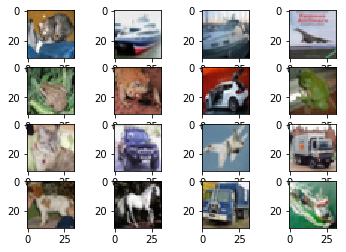

In [5]:
from matplotlib import pyplot
from scipy.misc import toimage
from keras.datasets import cifar10
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()
 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
show_imgs(x_test[:16])


In [6]:
x_test.shape

(10000, 32, 32, 3)

In [0]:
# This function takes the entire traaining data and test data and corresponding categorical label and returns the corresponding data in class indices
def getThreeClassesTrainTest(class_indices,train_data,train_labels,test_data,test_labels):
  all_train_data = []
  all_train_data_label = []
  all_test_data = []
  all_test_data_label = []
  for ind in class_indices:
    this_class_location_train =  np.where(train_labels==ind)[0] # train_labels[train_labels == ind]
    this_class_data_train = train_data[this_class_location_train,:]
    this_class_data_train_label = train_labels[this_class_location_train]
    print(this_class_location_train)
    
    this_class_location_test = np.where(test_labels==ind)[0] #test_labels[test_labels == ind]
    this_class_data_test = test_data[this_class_location_test,:]
    this_class_data_test_label = test_labels[this_class_location_test]
    
    all_train_data.append(this_class_data_train)
    all_test_data.append(this_class_data_test)
    all_train_data_label.append(this_class_data_train_label)
    all_test_data_label.append(this_class_data_test_label)
    
  train_data_three = all_train_data[0]
  train_label_three = all_train_data_label[0]
  test_data_three = all_test_data[0]
  test_label_three = all_test_data_label[0]
  
  for j in range(1,len(class_indices)):
    train_data_three = np.concatenate((train_data_three,all_train_data[j]))
    train_label_three = np.concatenate((train_label_three,all_train_data_label[j]))

    test_data_three = np.concatenate((test_data_three,all_test_data[j]))
    test_label_three = np.concatenate((test_label_three,all_test_data_label[j]))
  print(train_label_three.shape)
  train_label_three = np.reshape(train_label_three,newshape=(-1,))
  test_label_three = np.reshape(test_label_three,newshape=(-1,))
  return train_data_three, train_label_three, test_data_three,test_label_three

### Get only three classes of data and train the model on it

In [0]:
# train_three_data,train_three_label,test_three_data,test_three_label = getThreeClassesTrainTest([ 1,8,9 ],x_train,y_train,x_test,y_test)

In [0]:
# np.save('train_three_data_HiAcc.npy',train_three_data)
# np.save('train_three_label_HiAcc.npy',train_three_label)
# np.save('test_three_data_HiAcc.npy',test_three_data)
# np.save('test_three_label_HiAcc.npy',test_three_label)



In [0]:
train_three_data,train_three_label,test_three_data,test_three_label  =  (np.load('train_three_data_HiAcc.npy'),
                                                                         np.load('train_three_label_HiAcc.npy'),
                                                                         np.load('test_three_data_HiAcc.npy'),
                                                                         np.load('test_three_label_HiAcc.npy'))



(array([5000.,    0.,    0.,    0.,    0.,    0.,    0.,    0., 5000.,
        5000.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

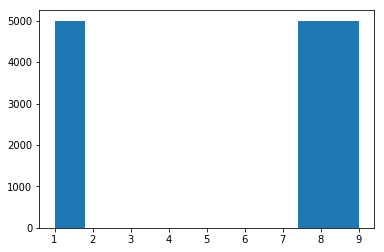

In [11]:
plt.hist(train_three_label)

(array([1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0., 1000.,
        1000.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

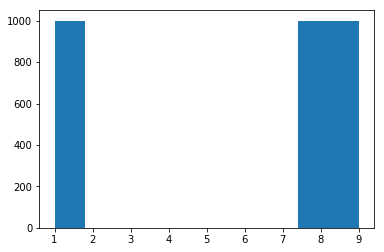

In [12]:
# test_three_label.shape
plt.hist(test_three_label)

In [0]:
train_three_data, train_three_label = shuffle(train_three_data, train_three_label )
test_three_data,test_three_label = shuffle(test_three_data,test_three_label )

In [0]:
le = preprocessing.LabelEncoder()
le.fit_transform(train_three_label)
train_three_label_cat = le.transform(train_three_label)
test_three_label_cat = le.transform(test_three_label)

In [15]:
train_three_label_cat.shape

(15000,)

In [0]:
train_three_label_one_hot = to_categorical(train_three_label_cat)
test_three_label_one_hot = to_categorical(test_three_label_cat)


In [17]:
test_three_label_one_hot.shape

(3000, 3)

In [0]:
# split train data and to create validation data
train_X,valid_X,train_ground,valid_ground = train_test_split(train_three_data,
                                                             train_three_label_one_hot,
                                                             test_size=0.2,
                                                             random_state=13)

In [0]:
num_classes = test_three_label_one_hot.shape[1]

In [0]:
x, y = 32, 32
inChannel = 3
input_img = Input(shape = (x, y, inChannel))
ep = 10 
weight_decay = 1e-4

In [0]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 33:
        lrate = 0.001/3
    if epoch > 66:
        lrate = 0.001/9
    return lrate

In [0]:
# def cifar10Classifier(input_img):
  
#   conv1 = (Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:], activation='elu'))(input_img)
#   conv1 = BatchNormalization()(conv1)
#   conv1 = (Conv2D(32, (3,3), padding='same', activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv1)
#   conv1 = BatchNormalization()(conv1)
#   pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
#   drop1= Dropout(.2)(pool1)

#   conv2 = (Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), activation='elu'))(drop1)
#   conv2 = BatchNormalization()(conv2)
#   conv2 = (Conv2D(64, (3,3), padding='same', activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv2)
#   conv2 = BatchNormalization()(conv2)
#   pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #14 x 14 x 32
#   drop2= Dropout(.3)(pool2)

#   conv3 = (Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), activation='elu'))(drop2)
#   conv3 = BatchNormalization()(conv3)
#   conv3 = (Conv2D(128, (3,3), padding='same', activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv3)
#   conv3 = BatchNormalization()(conv3)
#   pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #14 x 14 x 32
#   drop3= Dropout(.4)(pool3)

#   flat = Flatten()(drop3)
#   out = Dense(num_classes, activation='softmax')(flat)
  
#   return out

In [23]:
weight_decay

0.0001

In [0]:
from keras.layers import Activation

In [0]:
def cifar10Classifier(input_img):
  
  conv1_1 = (Conv2D(64, (3,3),name = 'conv1_1' ,padding='same', 
                    kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:],
                    activation='relu'))(input_img)
  conv1_2 = BatchNormalization(name = 'conv1_2')(conv1_1)
  pool1_3 = MaxPooling2D(pool_size=(2, 2), name = 'pool1_3')(conv1_2) #14 x 14 x 32
  conv2_1 = (Conv2D(128, (3,3),name = 'conv2_1' ,padding='same',
                    activation= 'relu',kernel_regularizer=regularizers.l2(weight_decay)))(pool1_3)
  conv2_2 = BatchNormalization(name = 'conv2_2')(conv2_1)
  pool2_3 = MaxPooling2D(pool_size=(2, 2), name = 'pool2_3')(conv2_2) #14 x 14 x 32
  
  conv3_1 = (Conv2D(256, (3,3), padding='same',name = 'conv3_1',
                    kernel_regularizer=regularizers.l2(weight_decay), activation='relu'))(pool2_3)
  conv3_2 = BatchNormalization(name = 'conv3_2')(conv3_1)
  conv4_1 = (Conv2D(256, (3,3), padding='same',name = 'conv4_1' ,activation= 'relu',
                    kernel_regularizer=regularizers.l2(weight_decay)))(conv3_2)
  conv4_2 = BatchNormalization(name = 'conv4_2')(conv4_1)
  pool4_2 = MaxPooling2D(pool_size=(2, 2), name = 'pool4_2')(conv4_2) #14 x 14 x 32
  
  conv5_1 = (Conv2D(512, (3,3), padding='same',name = 'conv5_1',
                    kernel_regularizer=regularizers.l2(weight_decay), activation='relu'))(pool4_2)
  conv5_2 = BatchNormalization(name = 'conv5_2')(conv5_1)
  conv6_1 = (Conv2D(512, (3,3), padding='same',name = 'conv6_1' ,activation= 'relu',
                    kernel_regularizer=regularizers.l2(weight_decay)))(conv5_2)
  conv6_2 = BatchNormalization(name = 'conv6_2')(conv6_1)
  pool6_2 = MaxPooling2D(pool_size=(2, 2), name = 'pool6_2')(conv6_2) #14 x 14 x 32
  
  conv7_1 = (Conv2D(512, (3,3), padding='same',name = 'conv7_1',
                    kernel_regularizer=regularizers.l2(weight_decay), activation='relu'))(pool6_2)
  conv7_2 = BatchNormalization(name = 'conv7_2')(conv7_1)
  conv8_1 = (Conv2D(512, (3,3), padding='same',name = 'conv8_1' ,activation= 'relu',
                    kernel_regularizer=regularizers.l2(weight_decay)))(conv7_2)
  conv8_2 = BatchNormalization(name = 'conv8_2')(conv8_1)
  pool8_2 = MaxPooling2D(pool_size=(2, 2), name = 'pool8_2')(conv8_2) #14 x 14 x 32


  flat = Flatten()(pool8_2)
  fc1 = Dense(4096, activation='relu', name = 'fc1')(flat)
  fc2 = Dense(4096, activation='relu', name = 'fc2')(fc1)
  fc3 = Dense(1000, activation='relu', name = 'fc3')(fc2)


  
  out = Dense(num_classes, activation='softmax', name = 'out')(fc3)
  
  return out

In [26]:
model = Model(input_img, (cifar10Classifier(input_img)))
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(train_three_data)
 
#training
batch_size = 64
 
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
# opt_rms = keras.optimizers.Adam(lr=0.001,decay=1e-6,beta_1=0.5)
# model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

model.compile(loss=losses.categorical_crossentropy, optimizer=opt_rms, metrics=['accuracy'])

model.summary()
 

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 32, 32, 64)        1792      
_________________________________________________________________
conv1_2 (BatchNormalization) (None, 32, 32, 64)        256       
_________________________________________________________________
pool1_3 (MaxPooling2D)       (None, 16, 16, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2_2 (BatchNormalization) (None, 16, 16, 128)       512       
_________________________________________________________________
pool

In [0]:
# model.get_weights()

In [0]:
mcp_save = ModelCheckpoint('weights.hdf5', save_best_only=True, monitor='val_acc', mode='auto')

In [0]:

# for l1,l2 in zip(model.layers[0:],loaded_model_high.layers[0:]):
#     l1.set_weights(l2.get_weights())

In [30]:
model.fit_generator(datagen.flow(train_X, train_ground, batch_size=batch_size),\
                    steps_per_epoch=train_X.shape[0] // batch_size,epochs=100,\
                    verbose=1,validation_data=(valid_X,valid_ground),
                    shuffle = True,callbacks=[mcp_save,LearningRateScheduler(lr_schedule)])
#save to disk
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5') 
 


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
187/187 [==============================] - 14s 77ms/step - loss: 10.6834 - acc: 0.3411 - val_loss: 10.7254 - val_acc: 0.3363
Epoch 2/100
187/187 [==============================] - 9s 50ms/step - loss: 4.5212 - acc: 0.4363 - val_loss: 3.8980 - val_acc: 0.4627
Epoch 3/100
187/187 [==============================] - 9s 48ms/step - loss: 0.8848 - acc: 0.5639 - val_loss: 0.9772 - val_acc: 0.5540
Epoch 4/100
187/187 [==============================] - 9s 48ms/step - loss: 0.7821 - acc: 0.6294 - val_loss: 1.6967 - val_acc: 0.4173
Epoch 5/100
187/187 [==============================] - 9s 47ms/step - loss: 0.7088 - acc: 0.7117 - val_loss: 0.7181 - val_acc: 0.7333
Epoch 6/100
187/187 [==============================] - 9s 47ms/step - loss: 0.5775 - acc: 0.8049 - val_loss: 0.7871 - val_acc: 0.6910
Epoch 7/100
187/187 [==============================] - 9s 47ms/step - loss: 0.5134 - acc: 0.8350 - val_loss: 0.7351 - val_acc: 0.7747
Epoch 8/100

In [0]:
model.load_weights('weights.hdf5')

In [0]:
model.save('vgg16HighAccuracyModelDataForTransferHi100Epoch.h5')


In [0]:
# temp_model = keras.models.load_model('lowAccuracyModelData.h5')
# temp_model.evaluate(valid_X, valid_ground, verbose=0)

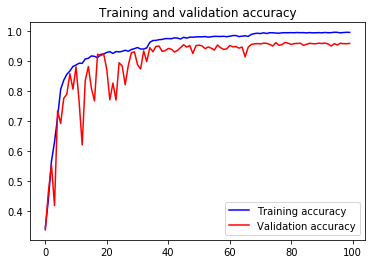

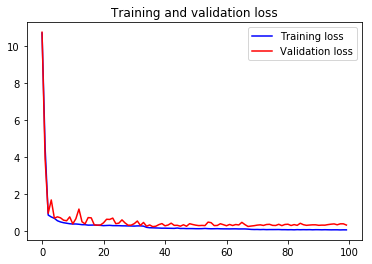

In [36]:
accuracy = model.history.history['acc']
val_accuracy = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [37]:
model.evaluate(valid_X, valid_ground, verbose=0)

[0.31499190600713095, 0.961]

In [38]:
#testing
test_eval = model.evaluate(test_three_data, test_three_label_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.368101234515508
Test accuracy: 0.9523333333333334


In [0]:
test_three_data.shape

(3000, 32, 32, 3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # Remove the CWD from sys.path while we load stuff.


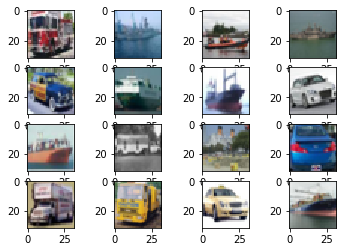

In [0]:
# show_imgs(test_three_data[:,1])
show_imgs(test_three_data[:16])

In [0]:
def getDIScoreOfLayer(layer_output, true_labels):
  # computeScatterMatrix
  rho = 1e-6
  mu = layer_output.mean(axis=0)
#   print(mu.shape)
  mu = mu.reshape((1,-1))
  centered_data = layer_output - mu
  S_bar = np.matmul(centered_data.T,centered_data)
  # compute between class matrix
  total_classes = true_labels.max()
  S_B = np.zeros(shape = (mu.shape[1],mu.shape[1]))
  S_W = np.zeros(shape = (mu.shape[1],mu.shape[1]))
  unique_classes = np.unique(true_labels)
  unique_classes_list = np.ndarray.tolist(unique_classes)
  for l in unique_classes_list:
    class_l_index = np.where(true_labels == l)
    class_l_output = layer_output[class_l_index[0],:]
    mu_l = class_l_output.mean(axis=0)
    mu_l = mu_l.reshape((1,-1))
    total_examples_this_class = class_l_index[0].shape   
    ss = mu_l - mu
    S_B = S_B + total_examples_this_class*np.matmul((mu_l - mu).T,(mu_l - mu))

  DI_Score = np.trace(np.matmul(np.linalg.inv(S_bar + rho*np.eye(S_bar.shape[0])),S_B))
  return DI_Score

In [0]:
def getDIScoreOfLayerCNNLayer(cnn_outputs, true_labels):
  # computeScatterMatrix
  number_of_filters = cnn_outputs.shape[3]
  cnn_di_scores = []
  for filt in range(0,number_of_filters):
    outputs_filter = cnn_outputs[:,:,:,filt]
    outputs_filter_reshaped = np.reshape(outputs_filter, newshape=(cnn_outputs.shape[0],-1))
    this_filter_score = getDIScoreOfLayer(outputs_filter_reshaped, true_labels)
    cnn_di_scores.append(this_filter_score)
  return cnn_di_scores

In [0]:
# layer_name
valid_X.shape

(3000, 32, 32, 3)

In [0]:
# train_three_data, train_three_label

In [0]:
layer_name = 'conv2d_6'
get_cnn1_output_function = K.function([model.layers[0].input],
                                  [model.get_layer(layer_name).output])   #get_layer test_three_label
cnn1_output = get_cnn1_output_function([train_three_data])[0]

ValueError: ignored

In [0]:
cnn1_output.shape

In [0]:
from keras.utils.vis_utils import plot_model

In [0]:
plot_model(model, to_file="cifar10Architecture.png", show_shapes=True, show_layer_names=True)

In [0]:
np.ndarray.tolist(np.unique(test_three_label))

[0, 3, 5]

In [0]:
# valid_ground_cat = np.argmax(train_ground, axis=1)
# # valid_ground_cat
# valid_ground.shape

In [0]:

di_scores = getDIScoreOfLayerCNNLayer(cnn1_output, train_three_label)

Mean of DI SCore:  0.46968247829146104
STD of DI Score:  0.17012919206958768
MAX of DI Score:  0.8879906467627727


(0, 1)

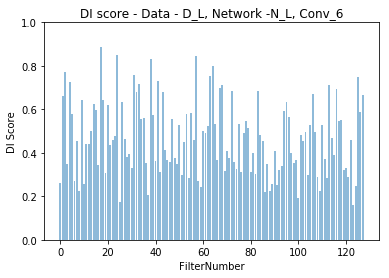

In [0]:
y_pos  = np.arange(len(di_scores))
plt.bar(y_pos, di_scores, align='center', alpha=0.5)
plt.xlabel('FilterNumber')
plt.ylabel('DI Score')

print('Mean of DI SCore: ',np.mean(di_scores))
print('STD of DI Score: ', np.std(di_scores))
print('MAX of DI Score: ', np.max(di_scores))
plt.title('DI score - Data - D_L, Network -N_L, Conv_6')
plt.ylim([0,1])

In [0]:
# model.summary()

## DI on different data

1.   List item
2.   List item



In [0]:

train_three_data_low,train_three_label_low,test_three_data_low,test_three_label_low = getThreeClassesTrainTest([1,8,9],x_train,y_train,x_test,y_test)

[    4     5    32 ... 49993 49998 49999]
[    8    62    69 ... 49968 49976 49985]
[    1     2    14 ... 49963 49971 49997]
(15000, 1)


In [0]:

# split train data and to create validation data
train_X_low,valid_X_low,train_ground_low,valid_ground_low = train_test_split(train_three_data_low,
                                                             train_three_label_low,
                                                             test_size=0.2,
                                                             random_state=13)

In [0]:
layer_name = 'conv2d_6'
get_cnn1_output_function_low = K.function([model.layers[0].input],
                                  [model.get_layer(layer_name).output])   #get_layer test_three_label
cnn1_output_low = get_cnn1_output_function_low([train_three_data_low])[0]
cnn1_output_low.shape

(15000, 8, 8, 128)

In [0]:
di_scores_low = getDIScoreOfLayerCNNLayer(cnn1_output_low, train_three_label_low)


Mean of DI SCore:  0.25325489539602447
STD of DI Score:  0.07981976639878438
MAX of DI Score:  0.48132421143127047


(0, 1)

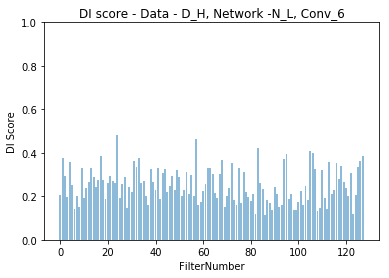

In [0]:
y_pos  = np.arange(len(di_scores_low))
plt.bar(y_pos, di_scores_low, align='center', alpha=0.5)
plt.xlabel('FilterNumber')
plt.ylabel('DI Score')

print('Mean of DI SCore: ',np.mean(di_scores_low))
print('STD of DI Score: ', np.std(di_scores_low))
print('MAX of DI Score: ', np.max(di_scores_low))
plt.title('DI score - Data - D_H, Network -N_L, Conv_6')
plt.ylim([0,1])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
__________

In [0]:
# # not working
# mat_save = {'diScore': di_scores, 'conv2d_1': cnn1_output, 'trueLabel':train_three_label}
# savemat('LowAccuracyConv2d_1MatrixMethod', mat_save) 

In [0]:
sum(di_scores)

14.049834714257239

In [0]:
max(di_scores)

0.6375973839423631

In [0]:
from scipy.io import savemat
